<a href="https://colab.research.google.com/github/georgeto20/CIS-700-008/blob/hw2/my_game_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected/
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

In [0]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description, end_game=False):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # True if entering this location should end the game
    self.end_game = end_game
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

In [0]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      items = preconditions[check]
      for item in items:
          if not game.is_in_inventory(item):
            all_conditions_met = False
            if print_failure_reasons:
              print("You don't have the %s" % item.name)
    if check == "inventory_does_not_contain":
      item = preconditions[check]
      if game.is_in_inventory(item):
        all_conditions_met = False
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    if check == "location_does_not_have_item":
      item = preconditions[check]
      if item.name in game.curr_location.items:
        all_conditions_met = False
    # todo - add other types of preconditions
  return all_conditions_met

In [0]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None,
               gettable=True,
               end_game=False,
               linger_tol=0,
               kill_text=""):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    # Indicates whether a player can get the object and put it in their inventory.
    self.gettable = gettable
    # True if entering this location should end the game.
    self.end_game = end_game
    # Number of moves player can make at location of character before character kills player (only relevant if >0).
    self.linger_tol = linger_tol
    # Linger tolerance at any given time.
    self.curr_linger_tol = linger_tol
    # Text that displays when player lingers in one location for too long and the game ends.
    self.kill_text = kill_text
    # Similarity threshold for finding most similar special command to user input
    self.threshold = 0.5
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

In [5]:
!pip3 install pymagnitude
!wget http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
#!wget http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude

from pymagnitude import *
vectors = Magnitude("glove.6B.300d.magnitude")
#vectors = Magnitude("GoogleNews-vectors-negative300.magnitude")

--2020-01-30 15:28:24--  http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.224.82
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.224.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1384890368 (1.3G) [binary/octet-stream]
Saving to: ‘glove.6B.300d.magnitude.1’

glove.6B.300d.magni 100%[===================>]   1.29G  64.0MB/s    in 20s     

2020-01-30 15:28:45 (64.5 MB/s) - ‘glove.6B.300d.magnitude.1’ saved [1384890368/1384890368]



In [6]:
!pip install allennlp

In [7]:
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/biaffine-dependency-parser-ptb-2018.08.23.tar.gz")

100%|██████████| 73228310/73228310 [00:03<00:00, 23408938.02B/s]
Did not use initialization regex that was passed: .*weight_hh.*
Did not use initialization regex that was passed: .*bias_ih.*
Did not use initialization regex that was passed: .*weight_ih.*
Did not use initialization regex that was passed: .*bias_hh.*


In [0]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      items_in_scope = self.game.get_items_in_scope()
      if " and " not in command:
          most_likely_item = items_in_scope[0]
          special_commands = list(most_likely_item.get_commands())
          most_likely_command, largest_similarity = "", 0
          if len(special_commands) > 0:
              most_likely_command, largest_similarity = self.find_most_similar_command(command, special_commands, vectors, most_likely_item.threshold)
          for i in range(1, len(items_in_scope)):
              special_commands = list(items_in_scope[i].get_commands())
              if len(special_commands) > 0:
                  most_similar_command, similarity = self.find_most_similar_command(command, special_commands, vectors, items_in_scope[i].threshold)
                  if similarity > largest_similarity:
                      most_likely_item = items_in_scope[i]
                      most_likely_command, largest_similarity = most_similar_command, similarity
          if largest_similarity > most_likely_item.threshold:
              return "special"
      pairs = self.verb_object_pairs(command)
      for pair in pairs:
          most_likely_item = items_in_scope[0]
          special_commands = list(most_likely_item.get_commands())
          most_likely_command, largest_similarity = "", 0
          if len(special_commands) > 0:
              most_likely_command, largest_similarity = self.find_most_similar_command(pair, special_commands, vectors, most_likely_item.threshold)
          for i in range(1, len(items_in_scope)):
              special_commands = list(items_in_scope[i].get_commands())
              if len(special_commands) > 0:
                  most_similar_command, similarity = self.find_most_similar_command(pair, special_commands, vectors, items_in_scope[i].threshold)
                  if similarity > largest_similarity:
                      most_likely_item = items_in_scope[i]
                      most_likely_command, largest_similarity = most_similar_command, similarity
          if largest_similarity > most_likely_item.threshold:
              return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.

    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    # Location before the player might go in some other direction
    prev_location = self.game.curr_location
    if intent == "direction":
      end_game = self.go_in_direction(command)
      # If player changed locations, then reset current linger tolerance to its original value
      if prev_location != self.game.curr_location:
          for item_name in self.game.curr_location.items:
              item = self.game.curr_location.items[item_name]
              if item.curr_linger_tol < item.linger_tol:
                  item.curr_linger_tol = item.linger_tol
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print("I'm not sure what you want to do.")
    # If player stayed in the same location or issued a different command, decrement current linger tolerance by 1
    if intent == "direction" and prev_location == self.game.curr_location or intent != "direction" and intent != "sequence":
        for item_name in self.game.curr_location.items:
            item = self.game.curr_location.items[item_name]
            if item.curr_linger_tol > 0:
                item.curr_linger_tol -= 1
                # Print warning message just before current linger tolerance reaches 0
                if item.curr_linger_tol == 1:
                    if not end_game:
                        print("You have one move remaining until the %s kills you." % item_name)
                # End the game if current linger tolerance reaches 0
                if item.curr_linger_tol == 0:
                    if not end_game:
                        print(item.kill_text)
                    end_game = True
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.end_game:
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.end_game

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: ", end = '')
      print(*descriptions, sep = ", ",)
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.gettable:
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.end_game
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")

  def run_single_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    items_in_scope = self.game.get_items_in_scope()
    most_likely_item = items_in_scope[0]
    special_commands = list(most_likely_item.get_commands())
    most_likely_command, largest_similarity = "", 0
    if len(special_commands) > 0:
        most_likely_command, largest_similarity = self.find_most_similar_command(command, special_commands, vectors, most_likely_item.threshold)
    for i in range(1, len(items_in_scope)):
        special_commands = list(items_in_scope[i].get_commands())
        if len(special_commands) > 0:
            most_similar_command, similarity = self.find_most_similar_command(command, special_commands, vectors, items_in_scope[i].threshold)
            if similarity > largest_similarity:
                most_likely_item = items_in_scope[i]
                most_likely_command, largest_similarity = most_similar_command, similarity
    if largest_similarity > most_likely_item.threshold:
        if not command.lower() in most_likely_item.get_commands():
            print("It seems you're trying to:", most_likely_command)
        return most_likely_item.do_action(most_likely_command, self.game)

  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    items_in_scope = self.game.get_items_in_scope()
    if " and " not in command:
        return self.run_single_special_command(command)
    pairs = self.verb_object_pairs(command)
    approved_pairs = []
    corresponding_items = []
    for pair in pairs:
        most_likely_item = items_in_scope[0]
        special_commands = list(most_likely_item.get_commands())
        most_likely_command, largest_similarity = "", 0
        if len(special_commands) > 0:
            most_likely_command, largest_similarity = self.find_most_similar_command(pair, special_commands, vectors, most_likely_item.threshold)
        for i in range(1, len(items_in_scope)):
            special_commands = list(items_in_scope[i].get_commands())
            if len(special_commands) > 0:
                most_similar_command, similarity = self.find_most_similar_command(pair, special_commands, vectors, items_in_scope[i].threshold)
                if similarity > largest_similarity:
                    most_likely_item = items_in_scope[i]
                    most_likely_command, largest_similarity = most_similar_command, similarity
        if largest_similarity > most_likely_item.threshold:
            if most_likely_command not in approved_pairs:
                if not pair.lower() in most_likely_item.get_commands():
                    print("It seems you're trying to:", most_likely_command)
                approved_pairs.append(most_likely_command)
                corresponding_items.append(most_likely_item)
    for i in range(len(approved_pairs)):
        end_game = corresponding_items[i].do_action(approved_pairs[i], self.game)
        if end_game:
            return True
    return False

  def construct_sentence_vector(self, command, vectors):
    sentence_vector = np.zeros(shape=(vectors.dim,))
    for word in command.split():
      word_vector = vectors.query(word)
      sentence_vector += word_vector
    sentence_vector /= len(command.split())
    return sentence_vector

  def find_most_similar_command(self, user_command, known_commands, vectors, threshold):
    constructed_user_command = self.construct_sentence_vector(user_command, vectors)
    most_similar_command = known_commands[0]
    constructed_known_command = self.construct_sentence_vector(known_commands[0], vectors)
    largest_similarity = vectors.similarity(constructed_user_command, constructed_known_command)
    for i in range(1, len(known_commands)):
        constructed_known_command = self.construct_sentence_vector(known_commands[i], vectors)
        current_similarity = vectors.similarity(constructed_user_command, constructed_known_command)
        if current_similarity > largest_similarity:
            most_similar_command = known_commands[i]
            largest_similarity = current_similarity
    if largest_similarity > threshold:
        return (most_similar_command, largest_similarity)
    else:
        return ("", 0)

  def verb_object_pairs(self, command):
    prediction = predictor.predict(sentence=command)

    words = prediction['words']
    pred_dependencies = prediction['predicted_dependencies']
    pred_heads = prediction['predicted_heads']

    pairs = []
    for i in range(len(words)):
      if pred_dependencies[i] == 'dobj':
        verb = words[pred_heads[i]-1] # -1 is bc head indices are one-indexed
        direct_object = words[i]
        pairs.append(verb + " " + direct_object)
    return pairs

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      end_game = self.parse_command(cmd)
      if end_game:
          return True

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None

In [0]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def add_action_to_character(game, *args):
  """Add new action to a character in the game."""
  (character, (new_commands)) = args[0]
  for command in new_commands:
      (command_text, function, arguments) = command
      character.add_action(command_text, function, arguments)
      print("\t", command_text)
  return False

def attempt_actions(game, *args):
  """Attempt actions and describe outcome based on
     whether or not item is in inventory."""
  (items, (actions), already_done_description, failure_action_description) = args[0]
  if game.is_in_inventory(items[0]):
      for action in actions:
          (function, arguments) = action
          end_the_game = function(game, arguments)
          if end_the_game:
            return True
  elif game.is_in_inventory(items[len(items)-1]):
      print(already_done_description)
  else:
      print(failure_action_description)
  return False

def change_description(game, *args):
  """Change description of an item or location."""
  (item_or_location, new_description) = args[0]
  item_or_location.description = new_description
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def create_item(game, *args):
  """Creates a new Item in the game."""
  (item, action_description) = args[0]
  game.curr_location.add_item(item.name, item)
  print(action_description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  return False

def perform_multiple_actions(game, *args):
  """Performs multuple actions at the same time."""
  (actions) = args[0]
  for action in actions:
      (function, arguments) = action
      end_the_game = function(game, arguments)
      if end_the_game:
        return True
  return False

def end_game(game, *args):
  """Ends the game."""
  (end_message) = args[0]
  print(end_message)
  return True

In [0]:
def build_game():
  # Locations
  home = Location("Home", "You are home.")
  pub = Location("Pub", "You are at the local pub.")
  bank = Location("Bank", "You are at the local bank.")
  bookstore = Location("Bookstore", "You are at the local bookstore.")
  pet_store = Location("Pet Store", "You are at the local pet store.")
  ship_bridge = Location("Ship Bridge", "You are at the bridge to the Vogon ship.")
  ship = Location("Ship", "You are standing in front of the Vogon ship.")

  # Connections
  home.add_connection("east", pub)
  pub.add_connection("east", bank)
  bank.add_connection("north", bookstore)
  bank.add_connection("south", pet_store)
  bank.add_connection("east", ship_bridge)
  ship_bridge.add_connection("east", ship)

  # Items that you can pick up
  money = Item("money", "some money", "The last pounds you will ever spend.", start_at=bank)
  # The following items are not gettable because the player must buy them rather than simply take them
  hitchhikers_guide = Item("guide", "the Hitchhiker's Guide to the Galaxy", "The space traveler's indispensable travel book.", start_at=bookstore, gettable=False)
  poetry_book = Item("poetry book", "a poetry book", "A classic poetry book.", start_at=bookstore, gettable=False)
  babel_fish = Item("babel fish", "a Babel fish", "The fish that translates from any language to any other language.", start_at=pet_store, gettable=False)

  # Sceneary (not things that you can pick up)
  ford = Item("ford", "Ford Prefect", "He looks like he's ready to head off into outer space or something.", start_at=home, gettable=False)
  local_pub = Item("pub", "the local pub", "The pub is lively with the confusion of its clientele over the menacing space ship that has landed nearby.",
                   start_at=pub, gettable=False, linger_tol=3, kill_text="Oh no! You lingered too long at the pub! When you return to your home, you find that it " +\
                   "has been destroyed to make space for a highway bypass.\nStricken with disbelief, you fall to the ground just as the Vogons are about to destroy " +\
                   "the Earth. THE END.")
  vogon = Item("vogon", "a smelly, menacing Vogon", "The Vogon will not budge until you give him the gift of poetry " +\
               "(according to Ford, the Vogons are quite fond of poetry).", start_at=ship_bridge, gettable=False)
  vogon_ship = Item("vogon ship", "the Vogon ship", "The ship is gigantic and indestructible.", start_at=ship, gettable=False)

  # Add special functions to your items
  ford.add_action("ask ford why he's here", describe_something, ("He tells you with a hint of urgency in his voice that the Vogons are about " +\
                    "to destroy the Earth.\n\"The Vogons?\" you ask.\n\"Yes,\" says Ford. \"I don't have time to explain.\""))
  ford.add_action("ask ford what you need to do", describe_something, ("He says, \"We must first buy a couple of things before we can leave this planet. " +\
                    "We must buy:\n1) a Babel fish, which translates any language to English in real time - otherwise, you won't understand a single word " +\
                    "those Vogon brats are saying.\n2) the universe-renowned Hitchhiker\'s Guide to the Galaxy, the quintessential book for any space traveler.\n" +\
                    "Once we get these things, it's bye-bye, Earth. We leave on the Vogon ship.\""))
  local_pub.add_action("talk to bartender", describe_something, ("He grins at you and says, \"Crazy how the world's about to end, eh?\""))
  local_pub.add_action("cry for help", describe_something, ("You shout, \"Can someone explain to me what the dickens is going on?\" but everyone just stares at you like you're a weirdo."))
  local_pub.add_action("buy drink", describe_something, ("You buy a drink and swallow it whole, but it hardly makes you feel any better."),
                 preconditions={"inventory_contains": [money]})
  hitchhikers_guide.add_action("buy hitchhiker's guide", perform_multiple_actions,
                         ([(destroy_item, (hitchhikers_guide, "You buy the Hitchhiker's Guide.")),
                         (add_item_to_inventory, (hitchhikers_guide, "It is now yours.", "You already bought the Hitchhiker's Guide."))
                         ]), preconditions={"inventory_contains": [money], "location_has_item": hitchhikers_guide})
  poetry_book.add_action("buy poetry book", perform_multiple_actions,
                         ([(destroy_item, (poetry_book, "You buy a poetry book.")),
                         (add_item_to_inventory, (poetry_book, "It is now yours.", "You already bought the poetry book."))
                         ]), preconditions={"inventory_contains": [money], "location_has_item": poetry_book})
  babel_fish.add_action("buy babel fish", perform_multiple_actions,
                         ([(destroy_item, (babel_fish, "You buy a Babel fish.")),
                         (add_item_to_inventory, (babel_fish, "It is now yours.", "You already bought the Babel fish."))
                         ]), preconditions={"inventory_contains": [money], "location_has_item": babel_fish})
  vogon.add_action("attack vogon", end_game, ("The Vogon annihilates you with his stinky breath. THE END."))
  vogon.add_action("give poetry book to vogon", perform_multiple_actions,
                    ([(destroy_item, (poetry_book, "You give the poetry book to the Vogon.")),
                    (destroy_item, (vogon, "He lets you pass."))
                    ]), preconditions={"inventory_contains": [poetry_book]})
  vogon_ship.add_action("sneak inside", end_game, ("Equipped with a Babel fish and a copy of the Hitchhiker's Guide, " +\
                                                   "you and Ford sneak inside the ship and wait until it takes off.\n" +\
                                                   "Congratulations! You are the only human survivor of Earth's destruction!"),
                                                    preconditions={"inventory_contains": [babel_fish, hitchhikers_guide]})

  # Add blocks to certain locations
  ship_bridge.add_block("east", "The Vogon blocks your way.", preconditions={"location_does_not_have_item": vogon})

  print("You are in a state of deep sleep, when suddenly, you are awoken by someone knocking on your door. It's your friend Ford Prefect.")
  game = Game(home)
  return game


In [47]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return

game_loop()
print('THE GAME HAS ENDED.')

You are in a state of deep sleep, when suddenly, you are awoken by someone knocking on your door. It's your friend Ford Prefect.
You are home.
Exits: East
You see: 
Ford Prefect
	 ask ford why he's here
	 ask ford what you need to do
>ask ford why he's here and what you need to do
It seems you're trying to: ask ford why he's here
It seems you're trying to: ask ford what you need to do
He tells you with a hint of urgency in his voice that the Vogons are about to destroy the Earth.
"The Vogons?" you ask.
"Yes," says Ford. "I don't have time to explain."
He says, "We must first buy a couple of things before we can leave this planet. We must buy:
1) a Babel fish, which translates any language to English in real time - otherwise, you won't understand a single word those Vogon brats are saying.
2) the universe-renowned Hitchhiker's Guide to the Galaxy, the quintessential book for any space traveler.
Once we get these things, it's bye-bye, Earth. We leave on the Vogon ship."
>ask ford what yo

You are in a state of deep sleep, when suddenly, you are awoken by someone knocking on your door. It's your friend Ford Prefect.


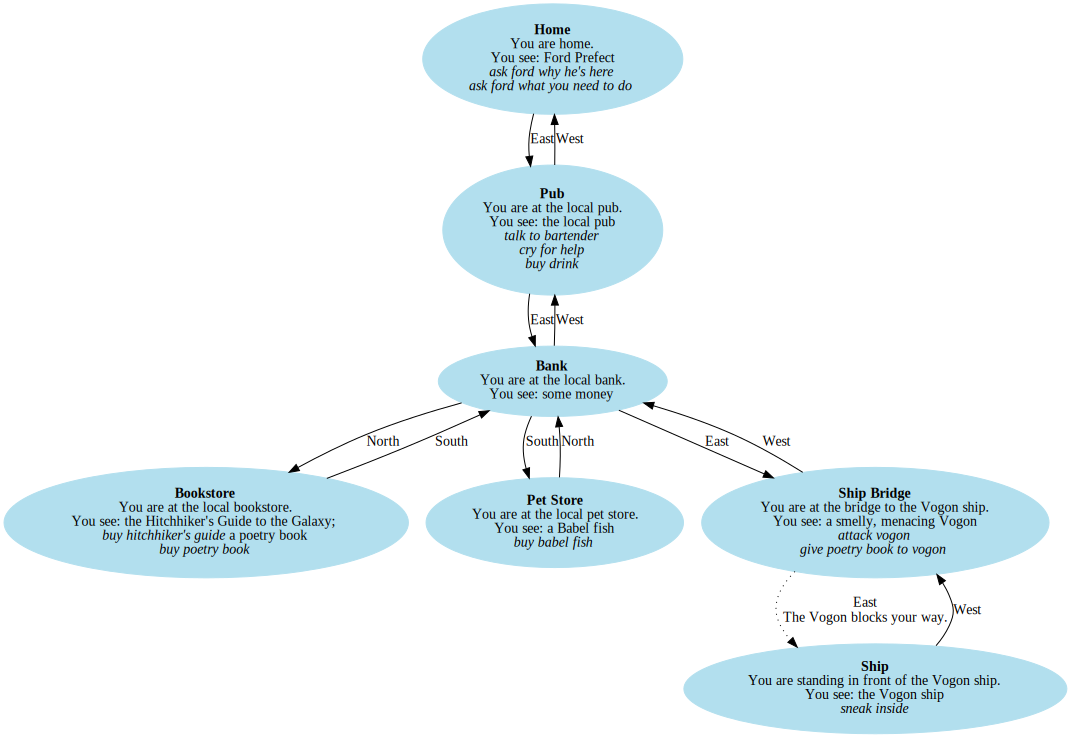

In [48]:
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for i, item_name in enumerate(location.items):
      item = location.items[item_name]
      items_html += item.description
      if i < len(location.items) - 1:
        items_html += "; "
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
#save_to_drive(graph)
graph
